In [84]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as anim
import numba as nb
from tqdm import tqdm 
import time

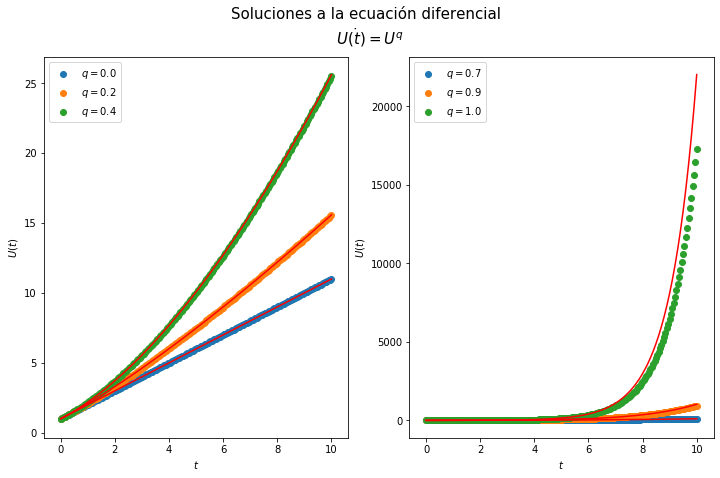

In [2]:
#Punto 1
q = np.array([0., 0.2, 0.4, 0.7, 0.9, 1.])
t = np.linspace(0,10,200)
h = t[1]-t[0]

def dU(u,q):
    return u**q

#Soluciones analíticas
def sol1(t):
    return np.exp(t)

def sol2(t,q):
    return (t*(1-q)+1)**(1/(1-q))

#Solucionando por diferencias finitas
def solDF(t,q):
    sol = np.zeros(len(t))
    sol[0] = 1
    
    for i in range(1,len(t)):
        sol[i] = dU(sol[i-1],q)*h + sol[i-1]
        
    return sol

figP1 = plt.figure(figsize=(12,7))
figP1.suptitle("Soluciones a la ecuación diferencial \n $\dot{U(t)} = U^q$",fontsize=15)
grP1 = figP1.add_subplot(121)
grP1.set_xlabel("$t$")
grP1.set_ylabel("$U(t)$")
grP12 = figP1.add_subplot(122)
grP12.set_xlabel("$t$")
grP12.set_ylabel("$U(t)$")

for i in range(3):
    grP1.scatter(t,solDF(t,q[i]),label="$q = {}$".format(q[i]))
    grP1.plot(t,sol2(t,q[i]),c="red")
    grP1.legend()
    
for i in range(3,5):
    grP12.scatter(t,solDF(t,q[i]),label="$q = {}$".format(q[i]))
    grP12.plot(t,sol2(t,q[i]),c="red")
    grP12.legend() 
    
grP12.scatter(t,solDF(t,q[-1]),label="$q = {}$".format(q[-1]))
grP12.plot(t,sol1(t),c="red")
grP12.legend()
    

<strong>Notas punto 1:</strong> <br>
1: El método de diferencias finitas no es el más preciso en general, aunque para resolver ecuaciones no lineales funciona muy bien. <br>
2: Las lineas rojas en las gráficas representan las soluciones analíticas.

In [3]:
#Punto 2
t = sy.Symbol("t",real=True)
h = sy.Symbol("h", real = True)
    
#Polinomio de Lagrange
def lagrange(i,k,bash):
    inicial = 1
    
    if bash == True: #Método de Adams-Bashforth
        for j in range(k):
            if (j != i):
                a = (j-i)*h
                inicial*= (t + j*h)/(a)     
                
    else: #Método de Adams-Moulton
        for j in range(k):
            if (j != i):
                a = (i-j)*h
                inicial*= (t - j*h)/(a)  
            
    return inicial
    
#Polinomio intepolador
def interp(k,bash):
    inicial = 0
    
    for i in range(k):
        inicial += sy.Symbol("f_n-{}".format(i))*lagrange(i,k,bash)
    
    return inicial

AB3 = sy.integrate(interp(3,True),(t,0,h)).expand().factor()
AB4 = sy.integrate(interp(4,True),(t,0,h)).expand().factor()
AB = [AB3,AB4]

AM3 = sy.integrate(interp(3,False),(t,0,h)).expand().factor()
AM4 = sy.integrate(interp(4,False),(t,0,h)).expand().factor()
AM = [AM3,AM4]

print("Coeficientes Adams-Bashforth")
for i in range(len(AB)):
    print("Grado {}:".format(i+3), AB[i])

print("\n")

print("Coeficientes Adams-Moulton")
for i in range(len(AM)):
    print("Grado {}:".format(i+3), AM[i])

Coeficientes Adams-Bashforth
Grado 3: h*(23*f_n-0 - 16*f_n-1 + 5*f_n-2)/12
Grado 4: h*(55*f_n-0 - 59*f_n-1 + 37*f_n-2 - 9*f_n-3)/24


Coeficientes Adams-Moulton
Grado 3: h*(5*f_n-0 + 8*f_n-1 - f_n-2)/12
Grado 4: h*(9*f_n-0 + 19*f_n-1 - 5*f_n-2 + f_n-3)/24


<strong>Nota punto 2:</strong> <br>
$f_{n-0} = f_n$

In [99]:
#Punto 3. Tomando la clase particle del repositorio
class Particle():
    
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt = t[1]-t[0]
        self.eps = 0.01 #Epsilon de tolerancia
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros((len(t),len(r0)))
        self.vVector = np.zeros((len(t),len(v0)))
        self.aVector = np.zeros((len(t),len(a0)))
        
        self.L = np.zeros(len(r0))
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        self.MomentumVector = np.zeros((len(t),len(v0)))
        
        self.EpVector = np.zeros((len(t),1))
        self.EkVector = np.zeros((len(t),1))
        
        
        self.Ep = 0.
        self.Force = self.m * self.a
        self.G = 4*np.pi**2
        
        self.rp = r0
        self.vp = v0
        
    def Evolution(self,i):
        
        # fill vectors
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetMomentum(i,self.m*self.v)
        
        
        # Energy 
        
        self.SetEk(i,self.GetKineticEnergy())
        self.SetEp(i,self.GetPotentialEnergy())
        
        # Change variables using the verlet method
        
        self.a = self.Force/self.m
        
     
        if i == 0:
            
            self.rp = self.r
            self.r = self.rp + self.dt * self.v
        
        else:
            
            self.rf = 2*self.r - self.rp + self.a * self.dt**2            
            self.v = ( self.rf - self.rp ) / (2*self.dt)
            
            self.rp = self.r
            self.r = self.rf
            
    def ResetForce(self):
        
        self.Force[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
        
    
    
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v   
        
    def SetMomentum(self,i,p):
        self.MomentumVector[i] = p
        
    def SetAngularMomentum(self,i,r,p):
        
    
        self.L[0] = r[1]*p[2] - r[2]*p[1]
        self.L[1] = -(r[0]*p[2] - r[2]*p[0])
        self.L[2] = r[0]*p[1] - r[1]*p[0]
        
        self.AngularMomentumVector[i] = self.L
            
    def SetEk(self,i,Ek):
        self.EkVector[i] = Ek
    
    def SetEp(self,i,Ep):
        self.EpVector[i] = Ep
        
    def GetForce(self,p):
        
        d = np.linalg.norm( self.r - p.GetPosition() )
        
        Fn = - self.G * self.m * p.m / (d**2+self.eps**2)**(3/2)
        
        self.Force = np.add( self.Force, Fn* (self.r - p.GetPosition())  )
        
        self.Ep += - self.G * self.m * p.m / d
                
    
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetReducePosition(self):
        return self.RrVector
        
    def GetVelocityVector(self):
        return self.vVector    
    
    def GetMomentumVector(self):
        return self.MomentumVector
    
    def GetAngularMomentumVector(self):
        return self.L
        
    def GetReduceVelocity(self):
        return self.RvVector
     
    def GetKineticEnergy(self):
        return 0.5*self.m*np.linalg.norm(self.v)**2
    
    def GetPotentialEnergy(self):
        #return -np.dot( self.m*self.a, self.r )
        return 0.5*self.Ep 
    
    def GetNetForce(self):
        return self.Force

    def GetR(self):
        return self.radius
  
    # Reducing size

    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])

In [100]:
#Generando los 100 planetas aleatorios
N = 100
m = 0.01
v = 0
dt = 0.001
t = np.arange(0,2,dt)

def GetParticles(NParticles,Limit,Velo,Dim = 3,dt=dt):
    
    Particles_ = []
    G = 4*np.pi**2
    
    for i in range(N):
        th, phi = np.random.uniform(0,2*np.pi,1), np.random.uniform(0,np.pi,1)
        r0 = np.zeros(Dim)
        r0[0] = np.array([np.cos(th)*np.sin(phi)])
        r0[1] = np.array([np.sin(th)*np.sin(phi)])
        r0[2] = np.array([np.cos(phi)])
        
        v0 = np.array([v,v,v])
        a0 = np.array([0.,0.,0.])
        
        p = Particle(r0,v0,a0,t,m,0.3,i)
        
        Particles_.append(p)
        
        
    return Particles_


In [101]:
#Corriendo la simulación
Limits = np.array([10.,10.,10.]) 

def RunSimulation(t,NParticles=N,Velo=v):
    
    # Creating the particles
    Particles = GetParticles(NParticles,Limits[0],Velo=v,dt=dt)
      
    for it in tqdm(range(len(t))):
        
        NetForce = np.array([0,0,0])
        
        for i in range(len(Particles)):    
            for j in range(len(Particles)):
                if i != j:
                    Particles[i].GetForce(Particles[j])
             
        #    NetForce = np.add(NetForce,Particles[i].GetNetForce())
            
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
            #Particles[i].CheckWallLimits(Limits)
             
        #print(NetForce)
        
    return Particles

universe = RunSimulation(t,N,v)



  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                 | 1/2000 [00:00<11:45,  2.83it/s]

  0%|                                                                                 | 2/2000 [00:00<11:41,  2.85it/s]

  0%|                                                                                 | 3/2000 [00:01<11:43,  2.84it/s]

  0%|▏                                                                                | 4/2000 [00:01<11:49,  2.81it/s]

  0%|▏                                                                                | 5/2000 [00:01<11:37,  2.86it/s]

  0%|▏                                                                                | 6/2000 [00:02<11:28,  2.90it/s]

  0%|▎                                                                                | 7/2000 [00:02<11:09,  2.98it/s]

  0%|▎                        

  3%|██▋                                                                             | 67/2000 [00:24<11:00,  2.93it/s]

  3%|██▋                                                                             | 68/2000 [00:24<10:50,  2.97it/s]

  3%|██▊                                                                             | 69/2000 [00:24<10:48,  2.98it/s]

  4%|██▊                                                                             | 70/2000 [00:25<10:52,  2.96it/s]

  4%|██▊                                                                             | 71/2000 [00:25<10:37,  3.02it/s]

  4%|██▉                                                                             | 72/2000 [00:25<10:38,  3.02it/s]

  4%|██▉                                                                             | 73/2000 [00:26<10:25,  3.08it/s]

  4%|██▉                                                                             | 74/2000 [00:26<10:40,  3.01it/s]

  4%|███                        

  7%|█████▎                                                                         | 134/2000 [00:49<11:17,  2.76it/s]

  7%|█████▎                                                                         | 135/2000 [00:49<11:13,  2.77it/s]

  7%|█████▎                                                                         | 136/2000 [00:50<11:34,  2.68it/s]

  7%|█████▍                                                                         | 137/2000 [00:50<11:32,  2.69it/s]

  7%|█████▍                                                                         | 138/2000 [00:50<11:30,  2.70it/s]

  7%|█████▍                                                                         | 139/2000 [00:51<11:10,  2.78it/s]

  7%|█████▌                                                                         | 140/2000 [00:51<11:17,  2.75it/s]

  7%|█████▌                                                                         | 141/2000 [00:52<11:10,  2.77it/s]

  7%|█████▌                     

 10%|███████▉                                                                       | 201/2000 [01:14<11:29,  2.61it/s]

 10%|███████▉                                                                       | 202/2000 [01:15<11:46,  2.54it/s]

 10%|████████                                                                       | 203/2000 [01:15<11:44,  2.55it/s]

 10%|████████                                                                       | 204/2000 [01:16<11:38,  2.57it/s]

 10%|████████                                                                       | 205/2000 [01:16<11:52,  2.52it/s]

 10%|████████▏                                                                      | 206/2000 [01:16<11:34,  2.58it/s]

 10%|████████▏                                                                      | 207/2000 [01:17<11:23,  2.62it/s]

 10%|████████▏                                                                      | 208/2000 [01:17<11:33,  2.58it/s]

 10%|████████▎                  

 13%|██████████▌                                                                    | 268/2000 [01:40<10:41,  2.70it/s]

 13%|██████████▋                                                                    | 269/2000 [01:40<11:10,  2.58it/s]

 14%|██████████▋                                                                    | 270/2000 [01:41<11:05,  2.60it/s]

 14%|██████████▋                                                                    | 271/2000 [01:41<10:51,  2.65it/s]

 14%|██████████▋                                                                    | 272/2000 [01:41<10:38,  2.70it/s]

 14%|██████████▊                                                                    | 273/2000 [01:42<10:39,  2.70it/s]

 14%|██████████▊                                                                    | 274/2000 [01:42<10:39,  2.70it/s]

 14%|██████████▊                                                                    | 275/2000 [01:43<10:53,  2.64it/s]

 14%|██████████▉                

 17%|█████████████▏                                                                 | 335/2000 [02:03<09:51,  2.81it/s]

 17%|█████████████▎                                                                 | 336/2000 [02:04<10:05,  2.75it/s]

 17%|█████████████▎                                                                 | 337/2000 [02:04<10:21,  2.68it/s]

 17%|█████████████▎                                                                 | 338/2000 [02:04<10:03,  2.75it/s]

 17%|█████████████▍                                                                 | 339/2000 [02:05<10:08,  2.73it/s]

 17%|█████████████▍                                                                 | 340/2000 [02:05<10:34,  2.62it/s]

 17%|█████████████▍                                                                 | 341/2000 [02:06<10:25,  2.65it/s]

 17%|█████████████▌                                                                 | 342/2000 [02:06<10:20,  2.67it/s]

 17%|█████████████▌             

 20%|███████████████▉                                                               | 402/2000 [02:28<08:13,  3.24it/s]

 20%|███████████████▉                                                               | 403/2000 [02:29<09:49,  2.71it/s]

 20%|███████████████▉                                                               | 404/2000 [02:29<08:47,  3.03it/s]

 20%|███████████████▉                                                               | 405/2000 [02:29<08:48,  3.02it/s]

 20%|████████████████                                                               | 406/2000 [02:30<08:59,  2.95it/s]

 20%|████████████████                                                               | 407/2000 [02:30<08:35,  3.09it/s]

 20%|████████████████                                                               | 408/2000 [02:30<08:51,  2.99it/s]

 20%|████████████████▏                                                              | 409/2000 [02:31<08:59,  2.95it/s]

 20%|████████████████▏          

 23%|██████████████████▌                                                            | 469/2000 [02:50<08:23,  3.04it/s]

 24%|██████████████████▌                                                            | 470/2000 [02:51<08:29,  3.01it/s]

 24%|██████████████████▌                                                            | 471/2000 [02:51<08:29,  3.00it/s]

 24%|██████████████████▋                                                            | 472/2000 [02:51<08:30,  2.99it/s]

 24%|██████████████████▋                                                            | 473/2000 [02:52<08:48,  2.89it/s]

 24%|██████████████████▋                                                            | 474/2000 [02:52<08:42,  2.92it/s]

 24%|██████████████████▊                                                            | 475/2000 [02:52<08:43,  2.91it/s]

 24%|██████████████████▊                                                            | 476/2000 [02:53<08:36,  2.95it/s]

 24%|██████████████████▊        

 27%|█████████████████████▏                                                         | 536/2000 [03:13<08:10,  2.99it/s]

 27%|█████████████████████▏                                                         | 537/2000 [03:13<08:06,  3.01it/s]

 27%|█████████████████████▎                                                         | 538/2000 [03:13<08:02,  3.03it/s]

 27%|█████████████████████▎                                                         | 539/2000 [03:14<08:17,  2.93it/s]

 27%|█████████████████████▎                                                         | 540/2000 [03:14<08:23,  2.90it/s]

 27%|█████████████████████▎                                                         | 541/2000 [03:14<08:09,  2.98it/s]

 27%|█████████████████████▍                                                         | 542/2000 [03:15<08:03,  3.01it/s]

 27%|█████████████████████▍                                                         | 543/2000 [03:15<08:07,  2.99it/s]

 27%|█████████████████████▍     

 30%|███████████████████████▊                                                       | 603/2000 [03:35<07:36,  3.06it/s]

 30%|███████████████████████▊                                                       | 604/2000 [03:35<07:35,  3.06it/s]

 30%|███████████████████████▉                                                       | 605/2000 [03:36<07:37,  3.05it/s]

 30%|███████████████████████▉                                                       | 606/2000 [03:36<07:38,  3.04it/s]

 30%|███████████████████████▉                                                       | 607/2000 [03:36<07:33,  3.07it/s]

 30%|████████████████████████                                                       | 608/2000 [03:37<07:30,  3.09it/s]

 30%|████████████████████████                                                       | 609/2000 [03:37<07:32,  3.07it/s]

 30%|████████████████████████                                                       | 610/2000 [03:37<07:36,  3.05it/s]

 31%|████████████████████████▏  

 34%|██████████████████████████▍                                                    | 670/2000 [03:57<07:04,  3.13it/s]

 34%|██████████████████████████▌                                                    | 671/2000 [03:57<07:21,  3.01it/s]

 34%|██████████████████████████▌                                                    | 672/2000 [03:58<07:05,  3.12it/s]

 34%|██████████████████████████▌                                                    | 673/2000 [03:58<07:12,  3.07it/s]

 34%|██████████████████████████▌                                                    | 674/2000 [03:58<07:18,  3.03it/s]

 34%|██████████████████████████▋                                                    | 675/2000 [03:59<07:27,  2.96it/s]

 34%|██████████████████████████▋                                                    | 676/2000 [03:59<07:13,  3.06it/s]

 34%|██████████████████████████▋                                                    | 677/2000 [03:59<07:18,  3.02it/s]

 34%|██████████████████████████▊

 37%|█████████████████████████████                                                  | 737/2000 [04:19<07:16,  2.90it/s]

 37%|█████████████████████████████▏                                                 | 738/2000 [04:19<07:11,  2.92it/s]

 37%|█████████████████████████████▏                                                 | 739/2000 [04:19<07:06,  2.96it/s]

 37%|█████████████████████████████▏                                                 | 740/2000 [04:20<07:10,  2.93it/s]

 37%|█████████████████████████████▎                                                 | 741/2000 [04:20<07:02,  2.98it/s]

 37%|█████████████████████████████▎                                                 | 742/2000 [04:20<06:55,  3.03it/s]

 37%|█████████████████████████████▎                                                 | 743/2000 [04:21<06:54,  3.03it/s]

 37%|█████████████████████████████▍                                                 | 744/2000 [04:21<06:53,  3.04it/s]

 37%|███████████████████████████

 40%|███████████████████████████████▊                                               | 804/2000 [04:43<07:26,  2.68it/s]

 40%|███████████████████████████████▊                                               | 805/2000 [04:44<07:31,  2.65it/s]

 40%|███████████████████████████████▊                                               | 806/2000 [04:44<07:43,  2.57it/s]

 40%|███████████████████████████████▉                                               | 807/2000 [04:44<07:33,  2.63it/s]

 40%|███████████████████████████████▉                                               | 808/2000 [04:45<07:52,  2.52it/s]

 40%|███████████████████████████████▉                                               | 809/2000 [04:45<07:34,  2.62it/s]

 40%|███████████████████████████████▉                                               | 810/2000 [04:45<07:17,  2.72it/s]

 41%|████████████████████████████████                                               | 811/2000 [04:46<07:06,  2.79it/s]

 41%|███████████████████████████

 44%|██████████████████████████████████▍                                            | 871/2000 [05:06<06:16,  3.00it/s]

 44%|██████████████████████████████████▍                                            | 872/2000 [05:06<06:13,  3.02it/s]

 44%|██████████████████████████████████▍                                            | 873/2000 [05:06<06:08,  3.05it/s]

 44%|██████████████████████████████████▌                                            | 874/2000 [05:07<05:55,  3.16it/s]

 44%|██████████████████████████████████▌                                            | 875/2000 [05:07<06:01,  3.11it/s]

 44%|██████████████████████████████████▌                                            | 876/2000 [05:07<06:08,  3.05it/s]

 44%|██████████████████████████████████▋                                            | 877/2000 [05:08<06:06,  3.06it/s]

 44%|██████████████████████████████████▋                                            | 878/2000 [05:08<06:11,  3.02it/s]

 44%|███████████████████████████

 47%|█████████████████████████████████████                                          | 938/2000 [05:28<05:56,  2.98it/s]

 47%|█████████████████████████████████████                                          | 939/2000 [05:28<05:51,  3.02it/s]

 47%|█████████████████████████████████████▏                                         | 940/2000 [05:29<05:51,  3.02it/s]

 47%|█████████████████████████████████████▏                                         | 941/2000 [05:29<05:54,  2.99it/s]

 47%|█████████████████████████████████████▏                                         | 942/2000 [05:29<05:51,  3.01it/s]

 47%|█████████████████████████████████████▏                                         | 943/2000 [05:30<05:51,  3.01it/s]

 47%|█████████████████████████████████████▎                                         | 944/2000 [05:30<05:48,  3.03it/s]

 47%|█████████████████████████████████████▎                                         | 945/2000 [05:30<05:56,  2.96it/s]

 47%|███████████████████████████

 50%|███████████████████████████████████████▏                                      | 1005/2000 [05:49<05:25,  3.06it/s]

 50%|███████████████████████████████████████▏                                      | 1006/2000 [05:50<05:17,  3.13it/s]

 50%|███████████████████████████████████████▎                                      | 1007/2000 [05:50<05:14,  3.16it/s]

 50%|███████████████████████████████████████▎                                      | 1008/2000 [05:50<05:26,  3.04it/s]

 50%|███████████████████████████████████████▎                                      | 1009/2000 [05:51<05:33,  2.98it/s]

 50%|███████████████████████████████████████▍                                      | 1010/2000 [05:51<05:27,  3.03it/s]

 51%|███████████████████████████████████████▍                                      | 1011/2000 [05:51<05:47,  2.84it/s]

 51%|███████████████████████████████████████▍                                      | 1012/2000 [05:52<05:45,  2.86it/s]

 51%|███████████████████████████

 54%|█████████████████████████████████████████▊                                    | 1072/2000 [06:14<05:23,  2.87it/s]

 54%|█████████████████████████████████████████▊                                    | 1073/2000 [06:14<05:19,  2.90it/s]

 54%|█████████████████████████████████████████▉                                    | 1074/2000 [06:15<05:21,  2.88it/s]

 54%|█████████████████████████████████████████▉                                    | 1075/2000 [06:15<05:39,  2.72it/s]

 54%|█████████████████████████████████████████▉                                    | 1076/2000 [06:16<05:56,  2.59it/s]

 54%|██████████████████████████████████████████                                    | 1077/2000 [06:16<06:05,  2.53it/s]

 54%|██████████████████████████████████████████                                    | 1078/2000 [06:16<05:50,  2.63it/s]

 54%|██████████████████████████████████████████                                    | 1079/2000 [06:17<05:15,  2.92it/s]

 54%|███████████████████████████

 57%|████████████████████████████████████████████▍                                 | 1139/2000 [06:37<04:34,  3.13it/s]

 57%|████████████████████████████████████████████▍                                 | 1140/2000 [06:37<04:29,  3.20it/s]

 57%|████████████████████████████████████████████▍                                 | 1141/2000 [06:38<04:25,  3.23it/s]

 57%|████████████████████████████████████████████▌                                 | 1142/2000 [06:38<04:31,  3.16it/s]

 57%|████████████████████████████████████████████▌                                 | 1143/2000 [06:38<04:23,  3.25it/s]

 57%|████████████████████████████████████████████▌                                 | 1144/2000 [06:39<04:22,  3.26it/s]

 57%|████████████████████████████████████████████▋                                 | 1145/2000 [06:39<04:25,  3.22it/s]

 57%|████████████████████████████████████████████▋                                 | 1146/2000 [06:39<04:41,  3.04it/s]

 57%|███████████████████████████

 60%|███████████████████████████████████████████████                               | 1206/2000 [06:59<03:40,  3.60it/s]

 60%|███████████████████████████████████████████████                               | 1207/2000 [07:00<03:47,  3.49it/s]

 60%|███████████████████████████████████████████████                               | 1208/2000 [07:00<03:39,  3.61it/s]

 60%|███████████████████████████████████████████████▏                              | 1209/2000 [07:00<03:17,  4.01it/s]

 60%|███████████████████████████████████████████████▏                              | 1210/2000 [07:00<03:00,  4.38it/s]

 61%|███████████████████████████████████████████████▏                              | 1211/2000 [07:01<03:26,  3.83it/s]

 61%|███████████████████████████████████████████████▎                              | 1212/2000 [07:01<03:32,  3.71it/s]

 61%|███████████████████████████████████████████████▎                              | 1213/2000 [07:01<03:33,  3.69it/s]

 61%|███████████████████████████

 64%|█████████████████████████████████████████████████▋                            | 1273/2000 [07:21<04:03,  2.98it/s]

 64%|█████████████████████████████████████████████████▋                            | 1274/2000 [07:22<04:04,  2.98it/s]

 64%|█████████████████████████████████████████████████▋                            | 1275/2000 [07:22<04:00,  3.01it/s]

 64%|█████████████████████████████████████████████████▊                            | 1276/2000 [07:22<03:58,  3.03it/s]

 64%|█████████████████████████████████████████████████▊                            | 1277/2000 [07:23<03:53,  3.10it/s]

 64%|█████████████████████████████████████████████████▊                            | 1278/2000 [07:23<03:54,  3.08it/s]

 64%|█████████████████████████████████████████████████▉                            | 1279/2000 [07:23<03:51,  3.11it/s]

 64%|█████████████████████████████████████████████████▉                            | 1280/2000 [07:24<03:56,  3.05it/s]

 64%|███████████████████████████

 67%|████████████████████████████████████████████████████▎                         | 1340/2000 [07:44<03:34,  3.08it/s]

 67%|████████████████████████████████████████████████████▎                         | 1341/2000 [07:44<03:25,  3.20it/s]

 67%|████████████████████████████████████████████████████▎                         | 1342/2000 [07:44<03:23,  3.23it/s]

 67%|████████████████████████████████████████████████████▍                         | 1343/2000 [07:44<03:18,  3.30it/s]

 67%|████████████████████████████████████████████████████▍                         | 1344/2000 [07:45<03:12,  3.41it/s]

 67%|████████████████████████████████████████████████████▍                         | 1345/2000 [07:45<03:11,  3.41it/s]

 67%|████████████████████████████████████████████████████▍                         | 1346/2000 [07:45<03:15,  3.35it/s]

 67%|████████████████████████████████████████████████████▌                         | 1347/2000 [07:46<03:33,  3.06it/s]

 67%|███████████████████████████

 70%|██████████████████████████████████████████████████████▊                       | 1407/2000 [08:06<03:11,  3.09it/s]

 70%|██████████████████████████████████████████████████████▉                       | 1408/2000 [08:06<03:12,  3.08it/s]

 70%|██████████████████████████████████████████████████████▉                       | 1409/2000 [08:06<03:09,  3.12it/s]

 70%|██████████████████████████████████████████████████████▉                       | 1410/2000 [08:07<03:07,  3.14it/s]

 71%|███████████████████████████████████████████████████████                       | 1411/2000 [08:07<03:10,  3.09it/s]

 71%|███████████████████████████████████████████████████████                       | 1412/2000 [08:07<03:08,  3.12it/s]

 71%|███████████████████████████████████████████████████████                       | 1413/2000 [08:08<03:11,  3.07it/s]

 71%|███████████████████████████████████████████████████████▏                      | 1414/2000 [08:08<03:11,  3.06it/s]

 71%|███████████████████████████

 74%|█████████████████████████████████████████████████████████▍                    | 1474/2000 [08:30<03:03,  2.86it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1475/2000 [08:30<02:59,  2.92it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1476/2000 [08:31<02:56,  2.97it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1477/2000 [08:31<02:56,  2.97it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 1478/2000 [08:31<02:56,  2.95it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 1479/2000 [08:32<03:01,  2.87it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 1480/2000 [08:32<02:58,  2.91it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 1481/2000 [08:32<02:50,  3.04it/s]

 74%|███████████████████████████

 77%|████████████████████████████████████████████████████████████                  | 1541/2000 [08:52<02:27,  3.12it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 1542/2000 [08:53<02:26,  3.12it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 1543/2000 [08:53<02:24,  3.16it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 1544/2000 [08:53<02:24,  3.15it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1545/2000 [08:54<02:28,  3.06it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1546/2000 [08:54<02:30,  3.03it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1547/2000 [08:54<02:28,  3.04it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1548/2000 [08:55<02:29,  3.02it/s]

 77%|███████████████████████████

 80%|██████████████████████████████████████████████████████████████▋               | 1608/2000 [09:16<02:16,  2.87it/s]

 80%|██████████████████████████████████████████████████████████████▊               | 1609/2000 [09:16<02:08,  3.04it/s]

 80%|██████████████████████████████████████████████████████████████▊               | 1610/2000 [09:16<02:04,  3.12it/s]

 81%|██████████████████████████████████████████████████████████████▊               | 1611/2000 [09:17<02:17,  2.84it/s]

 81%|██████████████████████████████████████████████████████████████▊               | 1612/2000 [09:17<02:33,  2.53it/s]

 81%|██████████████████████████████████████████████████████████████▉               | 1613/2000 [09:18<02:42,  2.39it/s]

 81%|██████████████████████████████████████████████████████████████▉               | 1614/2000 [09:18<02:39,  2.42it/s]

 81%|██████████████████████████████████████████████████████████████▉               | 1615/2000 [09:19<02:37,  2.45it/s]

 81%|███████████████████████████

 84%|█████████████████████████████████████████████████████████████████▎            | 1675/2000 [09:39<02:05,  2.58it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 1676/2000 [09:40<01:59,  2.71it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 1677/2000 [09:40<01:47,  3.01it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 1678/2000 [09:40<01:46,  3.01it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 1679/2000 [09:41<01:44,  3.09it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1680/2000 [09:41<01:43,  3.08it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1681/2000 [09:41<01:44,  3.05it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1682/2000 [09:42<01:44,  3.05it/s]

 84%|███████████████████████████

 87%|███████████████████████████████████████████████████████████████████▉          | 1742/2000 [10:01<01:23,  3.08it/s]

 87%|███████████████████████████████████████████████████████████████████▉          | 1743/2000 [10:02<01:24,  3.03it/s]

 87%|████████████████████████████████████████████████████████████████████          | 1744/2000 [10:02<01:22,  3.09it/s]

 87%|████████████████████████████████████████████████████████████████████          | 1745/2000 [10:02<01:22,  3.08it/s]

 87%|████████████████████████████████████████████████████████████████████          | 1746/2000 [10:03<01:24,  2.99it/s]

 87%|████████████████████████████████████████████████████████████████████▏         | 1747/2000 [10:03<01:23,  3.02it/s]

 87%|████████████████████████████████████████████████████████████████████▏         | 1748/2000 [10:03<01:22,  3.04it/s]

 87%|████████████████████████████████████████████████████████████████████▏         | 1749/2000 [10:04<01:23,  3.00it/s]

 88%|███████████████████████████

 90%|██████████████████████████████████████████████████████████████████████▌       | 1809/2000 [10:23<01:00,  3.17it/s]

 90%|██████████████████████████████████████████████████████████████████████▌       | 1810/2000 [10:23<01:01,  3.11it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 1811/2000 [10:24<01:02,  3.04it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 1812/2000 [10:24<01:00,  3.11it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 1813/2000 [10:24<00:59,  3.15it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 1814/2000 [10:25<00:59,  3.12it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 1815/2000 [10:25<00:58,  3.16it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 1816/2000 [10:25<00:59,  3.12it/s]

 91%|███████████████████████████

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1876/2000 [10:46<00:41,  2.99it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1877/2000 [10:46<00:42,  2.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1878/2000 [10:46<00:44,  2.73it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1879/2000 [10:47<00:45,  2.65it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1880/2000 [10:47<00:45,  2.64it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1881/2000 [10:47<00:43,  2.74it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1882/2000 [10:48<00:43,  2.71it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1883/2000 [10:48<00:40,  2.86it/s]

 94%|███████████████████████████

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1943/2000 [11:08<00:19,  2.92it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1944/2000 [11:09<00:19,  2.90it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1945/2000 [11:09<00:18,  2.94it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1946/2000 [11:09<00:18,  2.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1947/2000 [11:10<00:18,  2.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1948/2000 [11:10<00:17,  2.98it/s]

 97%|████████████████████████████████████████████████████████████████████████████  | 1949/2000 [11:10<00:17,  2.89it/s]

 98%|████████████████████████████████████████████████████████████████████████████  | 1950/2000 [11:11<00:17,  2.93it/s]

 98%|███████████████████████████

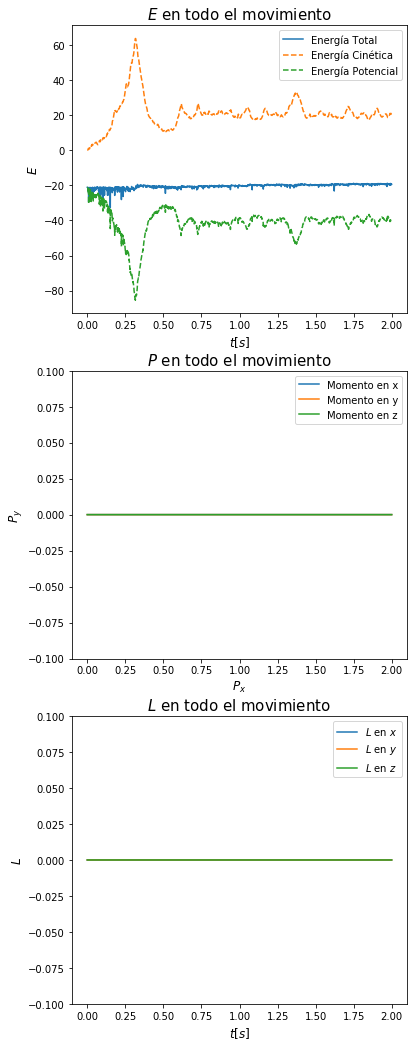

In [116]:
#Corriendo la simulacion y mirando cantidades conservadas
EnergiaK = universe[0].EkVector
EnergiaP = universe[0].EpVector
EnergiaTotal = universe[0].EkVector + universe[0].EpVector

for i in range(1,len(universe)):
    EnergiaK = np.add(EnergiaK, universe[i].EkVector)
    EnergiaP = np.add(EnergiaP, universe[i].EpVector)
    EnergiaTotal = np.add(EnergiaTotal, universe[i].EkVector + universe[i].EpVector) 

Momentum = universe[0].GetMomentumVector()
for i in range(1,len(universe)):
    Momentum = np.add(Momentum, universe[i].GetMomentumVector()) 
    
lMomentum = universe[0].GetAngularMomentumVector()
for i in range(1,len(universe)):
    lMomentum = np.add(lMomentum, universe[i].GetAngularMomentumVector()) 
    
fig1 = plt.figure(figsize=(6,18))
ax1 = fig1.add_subplot(3,1,1)
ax2 = fig1.add_subplot(3,1,2)
ax3 = fig1.add_subplot(3,1,3)

ax1.set_title("$E$ en todo el movimiento",fontsize=15)
ax1.plot(t,EnergiaTotal, label='Energía Total')
ax1.plot(t,EnergiaK,'--',label='Energía Cinética')
ax1.plot(t,EnergiaP,'--',label='Energía Potencial')
ax1.set_xlabel(r'$t[s]$',fontsize=12)
ax1.set_ylabel(r'$E$',fontsize=12)
#ax1.set_yscale('log')
ax1.legend(loc=0)


ax2.set_title("$P$ en todo el movimiento",fontsize=15)
ax2.plot(t,Momentum[:,0], label='Momento en x')
ax2.plot(t,Momentum[:,1], label='Momento en y')
ax2.plot(t,Momentum[:,2], label='Momento en z')
ax2.set_xlabel(r'$P_x$',fontsize=12)
ax2.set_ylabel(r'$P_y$',fontsize=12)
ax2.legend(loc=0)
ax2.set_ylim(-0.1,0.1)

ax3.set_title("$L$ en todo el movimiento",fontsize=15)
ax3.plot(t,lMomentum[0]*t,label="$L$ en $x$")
ax3.plot(t,lMomentum[1]*t,label="$L$ en $y$")
ax3.plot(t,lMomentum[2]*t,label="$L$ en $z$")
ax3.set_ylabel(r'$L$',fontsize=12)
ax3.set_xlabel(r'$t[s]$',fontsize=12)
ax3.legend(loc=0)
ax3.set_ylim(-0.1,0.1)

plt.show()

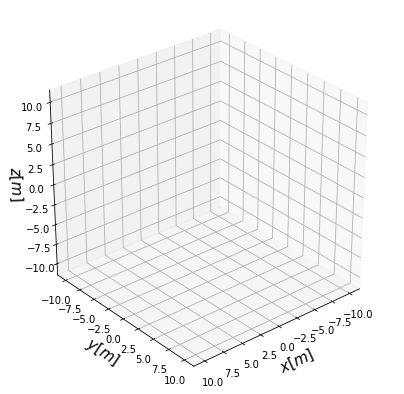

In [121]:
#Animando la solución
def ReduceTime(t,factor):
    
    for p in universe:
        p.ReduceSize(factor)
    
    Newt = []
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

redt = ReduceTime(t,100)

figP4 = plt.figure(figsize=(7,7))
ax = figP4.add_subplot(1,1,1, projection = '3d',elev = 30, azim = 50)
    
def init():
    ax.set_xlabel(r'$x[m]$',fontsize=15)
    ax.set_ylabel(r'$y[m]$',fontsize=15)
    ax.set_zlabel(r'$z[m]$',fontsize=15)
    ax.set_xlim(-Limits[0]-1,Limits[0]+1)
    ax.set_ylim(-Limits[1]-1,Limits[1]+1)
    ax.set_zlim(-Limits[2]-1,Limits[2]+1)

def Update(i):
    
    plot = ax.clear()
    init()
    
    j = 0
    
    for p in universe:
        
        x = p.GetReducePosition()[i,0]
        y = p.GetReducePosition()[i,1]
        z = p.GetReducePosition()[i,2]
        
        vx = p.GetReduceVelocity()[i,0]
        vy = p.GetReduceVelocity()[i,1]
        vz = p.GetReduceVelocity()[i,2]
        
        plot = ax.set_title(r'$t=%.2f \ years$' %(redt[i]))
        
        plot = ax.scatter(x,y,z,marker='.')
        
        plot = ax.quiver(x,y,z,vx,vy,vz,length = 0.05, normalize=False)
        j += 1
        
    plot = ax.legend()
            
    return plot
    
Animation = anim.FuncAnimation(figP4,Update,frames=len(redt),init_func=init)

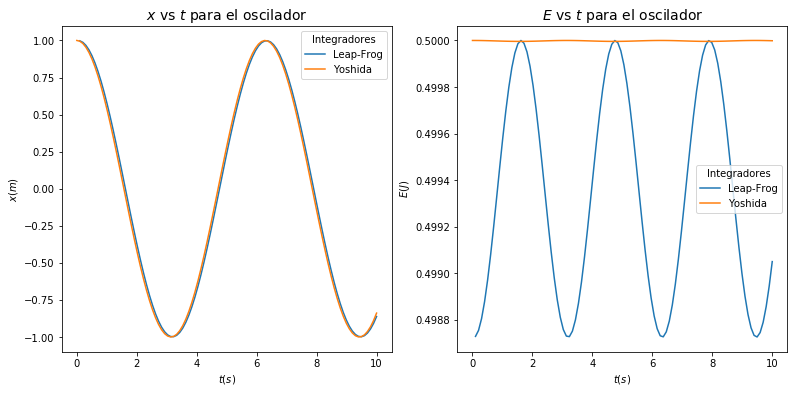

In [31]:
#Punto 4
#Coeficientes grado 4
c14 = 1/(2*(2-(2)**(1/3)))
c23 = (1-(2)**(1/3))/(2*(2-(2)**(1/3)))
c = np.array([c14,c23,c23,c14])

d13 = 1/(2-(2)**(1/3))
d2 = (-2**(1/3))/(2-(2)**(1/3))
d4 = 0
d = np.array([d13,d2,d13,d4])

#Condiciones iniciales y aceleracion
r0 = [1,0]
t = np.linspace(0,10,100)

def ac(x):
    return -x

#Implementando el integrador de cuarto orden
def yoshida():
    dt = t[1]-t[0]
    x = np.zeros(len(t))
    v = np.zeros(len(t))
    x[0] = r0[0]
    v[0] = r0[1]
    
    for i in range(1,len(x)):
        x1 = x[i-1] + c[0]*v[i-1]*dt
        v1 = v[i-1] + d[0]*ac(x1)*dt
        
        x2 = x1 + c[1]*v1*dt
        v2 = v1 + d[1]*ac(x2)*dt
        
        x3 = x2 + c[2]*v2*dt
        v3 = v2 + d[2]*ac(x3)*dt
        
        x4 = x3 + c[3]*v3*dt
        v4 = v3 + d[3]*ac(x4)*dt
        
        x[i] = x4
        v[i] = v4
        
    return x,v

xY,vY = yoshida()
eY = 0.5*xY**2+0.5*vY**2

#Comparando con Leap-Frog (tomado del GitHub de la clase)
def GetLeapFrog(r0,t):
    
    N = len(t)
    h = t[1] - t[0]
    
    t1 = np.arange(t[0] - 0.5*h, t[-1] - 0.5*h + h, h)
    
    x = np.zeros(N)
    v = np.zeros(N) # El inicializador

    x[0] = r0[0]
    v[0] = r0[1] - 0.5*h*ac(x[0])
    
    for i in range(1,N):
        
        v[i] = v[i-1] + h*ac(x[i-1])
        x[i] = x[i-1] + h*v[i]
    
    # Igualando los array
    X = np.array([])
    for i in range(len(x)-1):
        X = np.append(X,(x[i]+x[i+1])*0.5)

    V = v[1:]
    return X,V

xLF, vLF = GetLeapFrog(r0,t)
eLF = 0.5*xLF**2+0.5*vLF**2

figP4 = plt.figure(figsize=(13,6))
grP4 = figP4.add_subplot(121)
grP4.set_title("$x$ vs $t$ para el oscilador",fontsize=14)
grP4.plot(t[1::],xLF,label="Leap-Frog")
grP4.plot(t,xY,label="Yoshida")
grP4.set_xlabel("$t (s)$")
grP4.set_ylabel("$x (m)$")
grP4.legend(title="Integradores")

grP42 = figP4.add_subplot(122)
grP42.set_title("$E$ vs $t$ para el oscilador",fontsize=14)
grP42.plot(t[1::],eLF,label="Leap-Frog")
grP42.plot(t,eY,label="Yoshida")
grP42.set_xlabel("$t (s)$")
grP42.set_ylabel("$E (J)$")
grP42.legend(title="Integradores")